# Importing Required Liberaries

In [1]:

import os
from IPython.display import clear_output
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img,array_to_img
import numpy as np
import tensorflow as tf
from sklearn.externals import joblib
from skimage.color import rgb2gray
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D,Dropout,Flatten,GaussianNoise
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
import efficientnet.tfkeras as efn

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
# making distorted data
datagen = ImageDataGenerator(
        rescale = 1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,
        validation_split=0.1)  # randomly flip images


In [4]:
# setting hyper parameters
batch_size = 8
img_width = 96
img_hight = 96
train_data_dir = 'new_data/'
EPOCHS=100

Spliting data into traininga and validation subsets

In [5]:
train = datagen.flow_from_directory(train_data_dir,
                                    target_size = (img_width,img_hight),
                                    batch_size = batch_size,
                                    class_mode = 'categorical',
                                    subset='training',
                                    shuffle = True)

val = datagen.flow_from_directory(train_data_dir,
                                    target_size = (img_width,img_hight),
                                    batch_size = batch_size,
                                    class_mode = 'categorical',
                                    subset='validation',
                                    shuffle = True)


Found 5294 images belonging to 3 classes.
Found 587 images belonging to 3 classes.


I am using MobileNetV2 model becaused it performed best over efficientNets, SqueezeNets

In [6]:

def get_model():
    with strategy.scope():
        model = tf.keras.Sequential([
            tf.keras.applications.MobileNetV2(
                input_shape=(img_width,img_hight, 3),
                weights="imagenet",
                include_top=False
            ),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation = 'relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(3, activation='sigmoid')
        ])
        model.compile(
            optimizer='adam',
            loss = 'categorical_crossentropy',
            metrics=[tf.keras.metrics.AUC(),'accuracy'])
    
    return model

In [7]:
model = get_model()

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 2,422,339
Trainable params: 2,388,227
Non-trainable params: 34,112
_________________________________________

Creating model checkpoints

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler


checkpointer = ModelCheckpoint(filepath='saver/mobilenetv2_complete_dataset.h5',monitor = 'val_loss',verbose=2,save_best_only=True)

Changing Learning rate helps the model to learn better and effective

Learning rate schedule: 1e-05 to 5e-05 to 1e-05


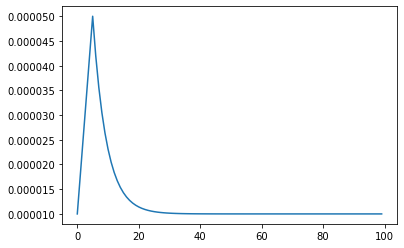

In [10]:
def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

I am using twice the data by using Image Data generators

In [11]:

train_steps_per_epoch = 2*(len(train) // batch_size)
val_steps_per_epoch = 2*(len(val) // batch_size)

# Training 

In [12]:
history = model.fit(train,
                    steps_per_epoch= train_steps_per_epoch,
                    epochs= EPOCHS,
                    validation_data= val ,
                    validation_steps= val_steps_per_epoch,
                    callbacks=[lr_schedule, checkpointer])

: 1.0000 - val_accuracy: 1.0000 - lr: 1.0001e-05

Epoch 00055: LearningRateScheduler reducing learning rate to 1.0000713623846353e-05.
Epoch 55/100
164/164 [==============================] - ETA: 0s - loss: 0.0853 - auc: 0.9885 - accuracy: 0.9718
Epoch 00055: val_loss did not improve from 0.00171
164/164 [==============================] - 10s 64ms/step - loss: 0.0853 - auc: 0.9885 - accuracy: 0.9718 - val_loss: 0.0068 - val_auc: 0.9998 - val_accuracy: 1.0000 - lr: 1.0001e-05

Epoch 00056: LearningRateScheduler reducing learning rate to 1.0000570899077083e-05.
Epoch 56/100
164/164 [==============================] - ETA: 0s - loss: 0.0815 - auc: 0.9895 - accuracy: 0.9726
Epoch 00056: val_loss did not improve from 0.00171
164/164 [==============================] - 10s 60ms/step - loss: 0.0815 - auc: 0.9895 - accuracy: 0.9726 - val_loss: 0.0148 - val_auc: 0.9997 - val_accuracy: 0.9931 - lr: 1.0001e-05

Epoch 00057: LearningRateScheduler reducing learning rate to 1.0000456719261668e-05.
Epo

Saving our Model Architecture

In [13]:
model_json = model.to_json()

with open('saver/mobilenetv2_complete_dataset.json','w') as json_file:

    json_file.write(model_json)